American Monte Carlo for Exposure Simulation
Copyright (c) 2016 Matthias Groncki

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

- Redistributions of source code must retain the above copyright notice,
this list of conditions and the following disclaimer.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDERS OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

This disclaimer is taken from the QuantLib license

In [1]:
# import the used libraries
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import QuantLib as ql
%matplotlib inline

In [2]:
# Setting evaluation date
today = ql.Date(7,4,2015)
ql.Settings.instance().setEvaluationDate(today)

In [3]:
# Setup Marketdata
rate = ql.SimpleQuote(0.03)
rate_handle = ql.QuoteHandle(rate)
dc = ql.Actual365Fixed()
yts = ql.FlatForward(today, rate_handle, dc)
yts.enableExtrapolation()
hyts = ql.RelinkableYieldTermStructureHandle(yts)
t0_curve = ql.YieldTermStructureHandle(yts)
euribor6m = ql.Euribor6M(hyts)
cal = ql.TARGET()

In [4]:
# Setup a dummy portfolio with two Swaps
def makeSwap(start, maturity, nominal, fixedRate, index, typ=ql.VanillaSwap.Payer):
    """
    creates a plain vanilla swap with fixedLegTenor 1Y
    
    parameter:
        
        start (ql.Date) : Start Date
        
        maturity (ql.Period) : SwapTenor
        
        nominal (float) : Nominal
        
        fixedRate (float) : rate paid on fixed leg
        
        index (ql.IborIndex) : Index
        
    return: tuple(ql.Swap, list<Dates>) Swap and all fixing dates
    
        
    """
    end = ql.TARGET().advance(start, maturity)
    fixedLegTenor = ql.Period("1y")
    fixedLegBDC = ql.ModifiedFollowing
    fixedLegDC = ql.Thirty360(ql.Thirty360.BondBasis)
    spread = 0.0
    fixedSchedule = ql.Schedule(start,
                                end, 
                                fixedLegTenor, 
                                index.fixingCalendar(), 
                                fixedLegBDC,
                                fixedLegBDC, 
                                ql.DateGeneration.Backward,
                                False)
    floatSchedule = ql.Schedule(start,
                                end,
                                index.tenor(),
                                index.fixingCalendar(),
                                index.businessDayConvention(),
                                index.businessDayConvention(),
                                ql.DateGeneration.Backward,
                                False)
    swap = ql.VanillaSwap(typ, 
                          nominal,
                          fixedSchedule,
                          fixedRate,
                          fixedLegDC,
                          floatSchedule,
                          index,
                          spread,
                          index.dayCounter())
    return swap, [index.fixingDate(x) for x in floatSchedule][:-1]


def makeSwaption(swap, callDates, settlement):
    """
    Creates the swaption of the underlying swap.
    
    If there is only one callDate in the list of call dates it will be a European swaption
    otherwise a Bermudan.
    """
    if len(callDates) == 1:
        exercise = ql.EuropeanExercise(callDates[0])
    else:
        exercise = ql.BermudanExercise(callDates)
    return ql.Swaption(swap, exercise, settlement)

Setup the Bermudan Swaption
1) Create a ATM plain vanilla swap using the helper function above and

2) create a bermudan swaption with yearly exercise dates.

In [218]:
settlementDate = today + ql.Period("2D")

swaps = [makeSwap(settlementDate,
                  ql.Period("5Y"),
                  1e6,
                  0.08,
                  euribor6m)
        ]

calldates = [ql.Date(7,4,2016), ql.Date(6,4,2017), ql.Date(5,4, 2018), ql.Date(5,4,2019)]
 
swaptions = [makeSwaption(swap, 
                          calldates, 
                          ql.Settlement.Physical) 
             for swap, fd in swaps]

calldates = [euribor6m.valueDate(d) for d in calldates]

In [219]:
#%%timeit
# Setup pricing engine and calculate the npv of the underlying swap
engine = ql.DiscountingSwapEngine(hyts)
for swap, fixingDates in swaps:
    swap.setPricingEngine(engine)
    print("Swap NPV at time 0: %.4f" % swap.NPV())

Swap NPV at time 0: -226395.0502


Setup the Gaussian Shortrate model (a.k.a Hull White model)
Don't worry about calibration, assume we know the calbriated model parameter

In [220]:
# Assume the model is already calibrated either historical or market implied
volas = [ql.QuoteHandle(ql.SimpleQuote(0.0075)),
         ql.QuoteHandle(ql.SimpleQuote(0.0075))]
meanRev = [ql.QuoteHandle(ql.SimpleQuote(0.002))]
model = ql.Gsr(t0_curve, [today+100], volas, meanRev, 16.)
process = model.stateProcess()

Calculate the swaption price using an integral pricing engine

In [221]:
swaptionEngine = ql.Gaussian1dSwaptionEngine(model)
for swaption in swaptions:
    swaption.setPricingEngine(swaptionEngine)
    print("Swaption NPV : %.2f" % swaption.NPV())

Swaption NPV : 3.49


Pricing with an Monte Carlo method
Create a swap path pricer in Python
Convert all Dates into times in years (using the same DayCounter as in the yieldTermStructure and store all fix cashflows in a numpy array.

In [222]:
mcDC = yts.dayCounter()

def timeFromReferenceFactory(daycounter, ref):
    """
    returns a function, that calculate the time in years
    from a the reference date *ref* to date *dat* 
    with respect to the given DayCountConvention *daycounter*
    
    Parameter:
        dayCounter (ql.DayCounter)
        ref (ql.Date)
        
    Return:
    
        f(np.array(ql.Date)) -> np.array(float)
    """
    def impl(dat):
        return daycounter.yearFraction(ref, dat)
    return np.vectorize(impl)

timeFromReference = timeFromReferenceFactory(mcDC, today)

In [223]:
def getFixedLeg(swap, t):
    """
    returns all future payment times and amounts of the fixed leg of the underlying swap
    
    Parameter:
        swap (ql.Swap)
        t (float) 
        
    Return:
        (np.array, np.array) (times, amounts)

    """
    fixed_leg = swap.leg(0)
    n = len(fixed_leg)
    fixed_times=[]
    fixed_amounts=[]
    npv = 0
    for i in range(n):
        cf = fixed_leg[i]
        t_i = timeFromReference(cf.date())
        if t_i > t:
            fixed_times.append(t_i)
            fixed_amounts.append(cf.amount())
    return np.array(fixed_times), np.array(fixed_amounts)


def getFloatingLeg(swap, t):
    """
    returns all future payment, fixing and accrual start and end times and amounts and nominals for all non fixed 
    periods of the floatiing leg
    
    Parameter:
        swap (ql.Swap)
        t (float) 
        
    Return:
        (np.array, np.array, np.array, np.array, np.array) (payment_times, accrual_period, accrual_start_time, accrual_end_time, nominals)

    """
    float_leg = swap.leg(1)
    n = len(float_leg)
    float_times = []
    float_dcf = []
    accrual_start_time = []
    accrual_end_time = []
    nominals = []
    for i in range(n):
        # convert base classiborstart_idx Cashflow to
        # FloatingRateCoupon
        cf = ql.as_floating_rate_coupon(float_leg[i])
        value_date = cf.referencePeriodStart()
        t_fix_i = timeFromReference(value_date)
        t_i = timeFromReference(cf.date()) 
        if t_fix_i >= t:
            iborIndex = cf.index()
            index_mat = cf.referencePeriodEnd()
            # year fraction
            float_dcf.append(cf.accrualPeriod())
            # calculate the start and end time
            accrual_start_time.append(t_fix_i)
            accrual_end_time.append(timeFromReference(index_mat))
            # payment time
            float_times.append(t_i)
            # nominals 
            nominals.append(cf.nominal())
    return np.array(float_times), np.array(float_dcf), np.array(accrual_start_time), np.array(accrual_end_time), np.array(nominals)

def getFixedFloatingPeriod(swap, t):
    """
    
    """
    float_leg = swap.leg(1)
    n = len(float_leg)
    for i in range(n):
        cf = ql.as_floating_rate_coupon(float_leg[i])
        value_date = cf.referencePeriodStart()
        t_fix_i = timeFromReference(value_date)
        t_i = timeFromReference(cf.date()) 
        if t_fix_i < t and t < t_i:
            iborIndex = cf.index()         
            index_mat = cf.referencePeriodEnd()
            # year fraction
            float_dcf = cf.accrualPeriod()
            # calculate the start and end time
            accrual_start_time = t_fix_i
            accrual_end_time = timeFromReference(index_mat)
            # payment time
            float_times = t_i
            # nominals 
            nominals = cf.nominal()
            return (float(float_times), float(float_dcf), float(accrual_start_time), float(accrual_end_time), float(nominals))
    return (float(t), 1., float(t), float(t), 0.)

def swapPathNPV(swap, t, timegrid):
    """
    Generate a path pricer. 
    
    The path pricer calculate the npv of the swap conditional 
    at time t on a given path of the short rate.
    """
    fixed_times, fixed_amounts = getFixedLeg(swap, t)
    float_times, float_dcf, accrual_start_time, accrual_end_time, nominals = getFloatingLeg(swap, t)
    df_times = np.concatenate([fixed_times, 
                           accrual_start_time, 
                           accrual_end_time, 
                           float_times])
    df_times = np.unique(df_times)
    # Store indices of fix leg payment times in 
    # the df_times array
    fix_idx = np.in1d(df_times, fixed_times, True)
    fix_idx = fix_idx.nonzero()
    # Indices of the floating leg payment times 
    # in the df_times array
    float_idx = np.in1d(df_times, float_times, True)
    float_idx = float_idx.nonzero()
    # Indices of the accrual start and end time
    # in the df_times array
    accrual_start_idx = np.in1d(df_times, accrual_start_time, True)
    accrual_start_idx = accrual_start_idx.nonzero()
    accrual_end_idx = np.in1d(df_times, accrual_end_time, True)
    accrual_end_idx = accrual_end_idx.nonzero()
    paytime_ffp, float_dcf_ffp, accrual_start_time_ffp, accrual_end_time_ffp, nominals_ffp = getFixedFloatingPeriod(swap, t)
    # Calculate NPV
    def calc(path):
        """
        Calculate the npv conditional on the given path 
        of the short rate.
        """
        if len(df_times)==0:
            return 0
        i = np.where(timegrid == t)[0][0]
        x_t = path[i]
        discount = np.vectorize(lambda T: model.zerobond(T, t, x_t))
        dfs = discount(df_times)
        # Calculate fixed leg npv
        fix_leg_npv = np.sum(fixed_amounts * dfs[fix_idx])
        # Estimate the index fixings
        index_fixings = (dfs[accrual_start_idx] / dfs[accrual_end_idx] - 1) 
        index_fixings /= float_dcf
        # Calculate the floating leg npv
        float_leg_npv = np.sum(nominals * index_fixings * float_dcf * dfs[float_idx])
        # Calculate the already fixed accrual period of the floating leg
        t_f = accrual_start_time_ffp
        i = np.where(timegrid == t_f)[0][0]
        x_f = path[i]
        df_e = model.zerobond(accrual_end_time_ffp, t_f, x_f)
        npv_accrualperiod = (1. / df_e - 1) * nominals_ffp * model.zerobond(paytime_ffp, t, x_t)
        # Calculate swap npv
        npv = float_leg_npv + npv_accrualperiod - fix_leg_npv
        return npv
    return calc

In [224]:
# Convert call date to time
callTimes = timeFromReference(calldates)
callTimes

array([ 1.01369863,  2.0109589 ,  3.00821918,  4.00821918])

In [225]:
swap = swaps[0][0]
swaption = swaptions[0]

In [226]:
npv = swapPathNPV(swap, 0., np.array([0.]))(np.array([0.]))
print("Swap NPV at time 0: %.4f" % npv)
print("Error : %.8f" % (npv - swap.NPV()))

Swap NPV at time 0: -226395.0502
Error : 0.00000000


Monte Carlo Simulation
Generate time grid and paths

In [227]:
def fixingdates(swap):
    leg = swap.leg(1)
    n = len(leg)
    fixing_dates = []
    for i in range(0, n):
        cf = ql.as_floating_rate_coupon(leg[i])
        value_date = cf.referencePeriodStart()
        fixing_dates.append(value_date)
    return fixing_dates

# Define evaluation grid
fixing_dates = fixingdates(swap)
fixing_times = timeFromReference(fixing_dates )

date_grid = [today + ql.Period(i, ql.Months) for i in range(0,66)] + calldates + fixing_dates

date_grid = np.unique(np.sort(date_grid))
time_grid = np.vectorize(lambda x: ql.Actual365Fixed().yearFraction(today, x))(date_grid)
time_grid = np.unique(time_grid)
dt = time_grid[1:] - time_grid[:-1]

In [228]:
# Random number generator
seed = 1
urng = ql.MersenneTwisterUniformRng(seed)
usrg = ql.MersenneTwisterUniformRsg(len(time_grid)-1,urng)
generator = ql.InvCumulativeMersenneTwisterGaussianRsg(usrg)

In [229]:
#%%timeit
# Generate N paths
M = 10000
m = len(time_grid)
x = np.zeros((M, m))
y = np.zeros((M, m))
numeraires = np.zeros((M, m))
                      
for n in range(0, M):
    numeraires[n, 0] = model.numeraire(0, 0)
    
for n in range(0,M):
    dWs = generator.nextSequence().value()
    j = 1
    for i in range(1, len(time_grid)):
        t0 = time_grid[i-1]
        t1 = time_grid[i]
        e = process.expectation(t0, 
                                x[n,i-1], 
                                dt[i-1])
        std = process.stdDeviation(t0,
                                   x[n,i-1],
                                   dt[i-1])
        x[n,i] = e + dWs[i-1] * std 
        e_0_0 = process.expectation(0,0,t1)
        std_0_0 = process.stdDeviation(0,0,t1)
        y[n,i] = (x[n,i] - e_0_0) / std_0_0
        numeraires[n, i] = model.numeraire(t1, y[n,i])
        #df_times_temp = df_times.copy()
        #df_times_temp[df_times_temp <= t1] = t1
        #dfs[n,i] = np.vectorize(lambda T: model.zerobond(T, t1, y[n,i]))(df_times_temp)

In [230]:
swap_npvs = np.zeros((M, m))
swaption_npvs = np.zeros((M, m))
cont_value = np.zeros(numeraires[:,i].shape)
for i in range(m-1, 0, -1):
    t = time_grid[i]
    print(t)
    pricer = swapPathNPV(swap, t, time_grid)
    swap_npvs[:, i] = np.apply_along_axis(pricer, 1, y) / numeraires[:, 0]
    exercise_values = np.zeros(numeraires[:,i].shape)
    if t in callTimes:
        exercise_values = swap_npvs[:, i].copy()
        exercise_values[exercise_values < 0] = 0
    states = y[:, i]
    Y = np.column_stack((states, states**2, states**3, states**4))
    Y = sm.add_constant(Y)
    ols = sm.OLS(cont_value, Y)
    ols_result = ols.fit()
    cont_value_hat = np.sum(ols_result.params * Y, axis=1)
    swaption_npvs[:,i] = np.maximum(cont_value_hat, exercise_values)
    if t in callTimes:
        print("Update")
        cont_value = np.maximum(cont_value_hat, exercise_values)
        swaption_npvs[cont_value_hat < exercise_values, i:] = swap_npvs[cont_value_hat < exercise_values, i:].copy()
swaption_npvs[:,0] = np.mean(cont_value)
swap_npvs[:, 0] = np.apply_along_axis(swapPathNPV(swap, 0, time_grid), 1, y) / numeraires[:, 0]

5.42465753425
5.3397260274
5.25479452055
5.17260273973
5.08767123288
5.00547945205
4.92054794521
4.84109589041
4.75616438356
4.67123287671
4.58904109589
4.5095890411
4.50410958904
4.42191780822
4.33698630137
4.25205479452
4.1698630137
4.08493150685
4.00821917808
Update
4.00273972603
3.91780821918
3.84109589041
3.75616438356
3.67123287671
3.58904109589
3.5095890411
3.50410958904
3.42191780822
3.33698630137
3.25205479452
3.1698630137
3.08493150685
3.00821917808
Update
3.00273972603
2.91780821918
2.84109589041
2.75616438356
2.67123287671
2.58904109589
2.5095890411
2.50410958904
2.42191780822
2.33698630137
2.25205479452
2.1698630137
2.08493150685
2.01095890411
Update
2.00273972603
1.91780821918
1.84109589041
1.75616438356
1.67123287671
1.58904109589
1.51232876712
1.50410958904
1.42191780822
1.33698630137
1.25205479452
1.1698630137
1.08493150685
1.01369863014
Update
1.00273972603
0.917808219178
0.838356164384
0.753424657534
0.668493150685
0.586301369863
0.506849315068
0.501369863014
0.41917

In [231]:
swaption_npvs *= numeraires[0,0]
swap_npvs *= numeraires[0,0]

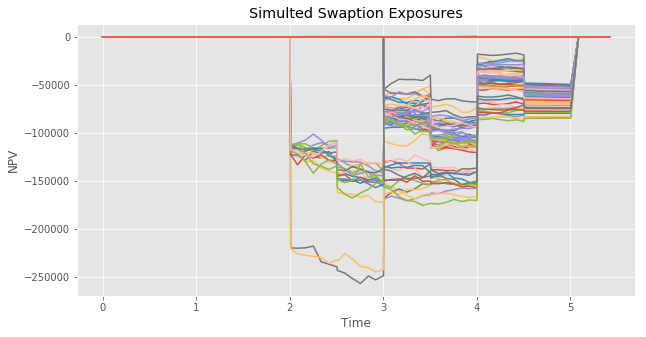

In [232]:
plt.figure(figsize=(10,5))
for i in range(1, 100):
    plt.plot(time_grid, swaption_npvs.T[:,i])
    plt.title("Simulted Swaption Exposures")
    plt.xlabel("Time")
    plt.ylabel("NPV")

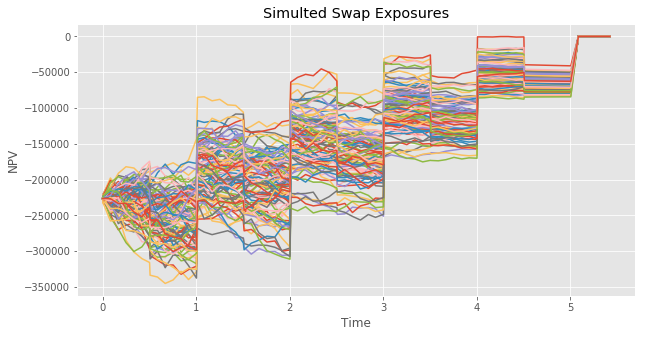

In [233]:
plt.figure(figsize=(10,5))
for i in range(1, 100):
    plt.plot(time_grid, swap_npvs.T[:,i])
    plt.title("Simulted Swap Exposures")
    plt.xlabel("Time")
    plt.ylabel("NPV")

In [234]:
# Expected Exposure
swap_npvs[swap_npvs<0] = 0
swaption_npvs[swaption_npvs<0] = 0
EE_swaption = np.mean(swaption_npvs, axis=0)
EE_swap = np.mean(swap_npvs, axis=0)

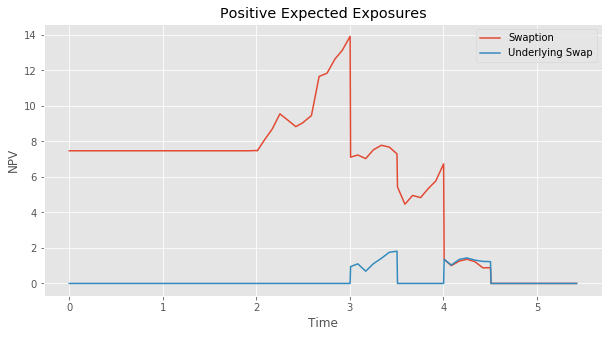

In [235]:
plt.figure(figsize=(10,5))
plt.title("Positive Expected Exposures")
plt.plot(time_grid, EE_swaption)
plt.plot(time_grid, EE_swap)
plt.xlabel("Time")
plt.ylabel("NPV")
plt.legend(["Swaption", "Underlying Swap"])

CVA

In [236]:
# Setup Default Curve 
pd_dates =  [today + ql.Period(i, ql.Years) for i in range(11)]
hzrates = [0.02 * i for i in range(11)]
pd_curve = ql.HazardRateCurve(pd_dates,hzrates,ql.Actual365Fixed())
pd_curve.enableExtrapolation()

Text(0.5,1,'Harzard rate')

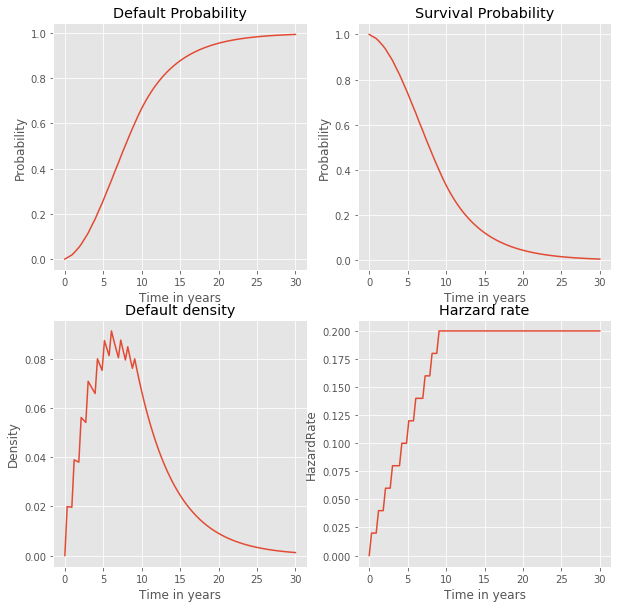

In [237]:
# Plot curve
# Calculate default probs on grid *times*
times = np.linspace(0,30,100)
dp = np.vectorize(pd_curve.defaultProbability)(times)
sp = np.vectorize(pd_curve.survivalProbability)(times)
dd = np.vectorize(pd_curve.defaultDensity)(times)
hr = np.vectorize(pd_curve.hazardRate)(times)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.plot(times, dp)
ax2.plot(times, sp)
ax3.plot(times, dd)
ax4.plot(times, hr)
ax1.set_xlabel("Time in years")
ax2.set_xlabel("Time in years")
ax3.set_xlabel("Time in years")
ax4.set_xlabel("Time in years")
ax1.set_ylabel("Probability")
ax2.set_ylabel("Probability")
ax3.set_ylabel("Density")
ax4.set_ylabel("HazardRate")
ax1.set_title("Default Probability")
ax2.set_title("Survival Probability")
ax3.set_title("Default density")
ax4.set_title("Harzard rate")

In [238]:
# Calculation of the default probs
defaultProb_vec = np.vectorize(pd_curve.defaultProbability)
dPD = defaultProb_vec(time_grid[:-1], time_grid[1:])

In [239]:
# Calculation of the CVA
recovery = 0.4
CVA = (1-recovery) * np.sum(EE_swaption[1:] * dPD)
CVA

0.89457570713147327

In [240]:
# Calculation of the CVA
recovery = 0.4
CVA = (1-recovery) * np.sum(EE_swap[1:] * dPD)
CVA

0.057947311871232809




fit GP

In [31]:
import os
os.environ['TF_C_API_GRAPH_CONSTRUCTION']='0'
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
from edward.models import Normal
import seaborn as sns
plt.style.use('ggplot')
from edward.models import MultivariateNormalTriL
from edward.util import rbf

In [243]:
# dataset initiation
#swaps_gp = [makeSwap(settlementDate, ql.Period("5Y"), 1e6, 0.03, euribor6m)]

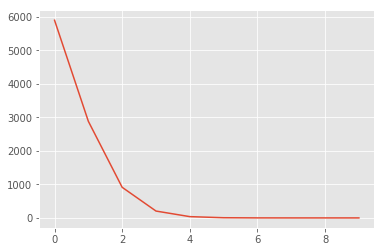

In [242]:
# CVA vs different fix rate of swap, change from 0.01 to 0.1 
CVA_fix = np.array([5901.3797828005836,2883.5699104367236,913.4,204.82055378641272,38.164562723122458,5.8741266072060876,0.78326262396065416,0.057947311871232809,0,0])
plt.plot(CVA_fix) 